# 의사결정나무 분류 decision tree classification
* **2학기**로 y = 각 시간별 주문 혼잡도 확인
* 기존 model/decisiontree_(학기).ipynb 파일들과 달리, **Ordinal Encoding**을 진행하고 시간의 경우 int형으로 넣어주는 시도 진행

### 라이브러리 임포트

In [1]:
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle

### data 불러오기

In [2]:
df = pd.read_excel("../resource/final_for_models.xlsx")
df.head()

,일자,semester,season,event,day of the week,time,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34


In [3]:
df = df.rename(columns = {'day of the week' : '요일', 'season' : '계절', 'semester' : '학기', 'time': 'hour'})   # 보기 편하게 열 이름 rename
df

,일자,학기,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34
...,...,...,...,...,...,...,...,...,...,...,...
1471,2022-12-21,2,11,2,2,13,0.3,0.8,0.0,89,40
1472,2022-12-21,2,11,2,2,14,0.6,1.0,0.0,88,39
1473,2022-12-21,2,11,2,2,15,2.0,0.1,0.0,83,22
1474,2022-12-21,2,11,2,2,16,0.7,0.5,0.0,89,27


In [4]:
# 2학기만 진행하기 때문에, 학기 열에 mask를 진행

df = df[df['학기'] == 2]
df.drop('학기', axis=1, inplace=True)

C:\Users\sohtk\AppData\Local\Temp\ipykernel_11032\1311148288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('학기', axis=1, inplace=True)


## Decision Tree 모델에 맞게 데이터 전처리

#### Categorical 데이터들을 Decision Tree 모델이 이해할 수 있는 **One-Hot Encoding**을 통해 binary data로 변환

In [5]:
# one-hot encoding을 위해, 숫자형으로 바꿨던 것을 다시 범주형으로 바꿔줌
# (기존에 정의한 함수 mapping 사용)

from model_prep.onehotmap import *

df = map_season(df, '계절')
df = map_event(df, 'event')
df = map_day(df, '요일')
df = map_hour_int(df, 'hour')

df.head()  # 바뀐 df 확인

c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\model\model_prep\onehotmap.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(str).replace(season_mapping)
c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\model\model_prep\onehotmap.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(str).replace(event_mapping)
c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\

,일자,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
726,2022-09-01,가을,평소,목요일,8,19.4,0.8,0.0,89,28
727,2022-09-01,가을,평소,목요일,9,21.2,1.5,0.0,81,31
728,2022-09-01,가을,평소,목요일,10,23.6,0.4,0.0,70,38
729,2022-09-01,가을,평소,목요일,11,25.2,1.9,0.0,63,102
730,2022-09-01,가을,평소,목요일,12,26.9,2.0,0.0,57,86


In [6]:
# df.to_excel('dt.xlsx', index=False)

In [7]:
# # Define a function to categorize hours into class periods
# def categorize_hour(hour):
#     if hour in [8, 9, 10, 11]:
#         return '1-2교시'
#     elif hour in [12, 13, 14]:
#         return '3-4교시'
#     elif hour in [15, 16, 17]:
#         return '5-6교시'
#     else:
#         return None


# Apply the function to the 'hour' column to create a new '교시' column
df['교시'] = df['hour'].apply(categorize_hour)

# Check the updated DataFrame
df.head()

C:\Users\sohtk\AppData\Local\Temp\ipykernel_11032\451381086.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['교시'] = df['hour'].apply(categorize_hour)


,일자,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,교시
726,2022-09-01,가을,평소,목요일,8,19.4,0.8,0.0,89,28,1-2교시
727,2022-09-01,가을,평소,목요일,9,21.2,1.5,0.0,81,31,1-2교시
728,2022-09-01,가을,평소,목요일,10,23.6,0.4,0.0,70,38,1-2교시
729,2022-09-01,가을,평소,목요일,11,25.2,1.9,0.0,63,102,1-2교시
730,2022-09-01,가을,평소,목요일,12,26.9,2.0,0.0,57,86,3-4교시


#### 일자 없애기
* decision tree에선 datetime 데이터 타입을 받을 수 없기 때문에 진행해줘야 함
* 슬라이싱 진행

In [8]:
data = df.iloc[:, 1:]
data

,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,교시
726,가을,평소,목요일,8,19.4,0.8,0.0,89,28,1-2교시
727,가을,평소,목요일,9,21.2,1.5,0.0,81,31,1-2교시
728,가을,평소,목요일,10,23.6,0.4,0.0,70,38,1-2교시
729,가을,평소,목요일,11,25.2,1.9,0.0,63,102,1-2교시
730,가을,평소,목요일,12,26.9,2.0,0.0,57,86,3-4교시
...,...,...,...,...,...,...,...,...,...,...
1471,겨울,시험,수요일,13,0.3,0.8,0.0,89,40,3-4교시
1472,겨울,시험,수요일,14,0.6,1.0,0.0,88,39,3-4교시
1473,겨울,시험,수요일,15,2.0,0.1,0.0,83,22,5-6교시
1474,겨울,시험,수요일,16,0.7,0.5,0.0,89,27,5-6교시


In [9]:
# 보기 쉬운 열 정렬로 직접 정렬해줌

data = data[['계절', 'event', '요일', '교시', 'hour',
             '기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', '합계']]

data.head()  # 정렬 모습 확인

,계절,event,요일,교시,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
726,가을,평소,목요일,1-2교시,8,19.4,0.8,0.0,89,28
727,가을,평소,목요일,1-2교시,9,21.2,1.5,0.0,81,31
728,가을,평소,목요일,1-2교시,10,23.6,0.4,0.0,70,38
729,가을,평소,목요일,1-2교시,11,25.2,1.9,0.0,63,102
730,가을,평소,목요일,3-4교시,12,26.9,2.0,0.0,57,86


### Decision Tree Classfication을 위해 혼잡도 계산
* 합계 열을 기준으로, 주문 혼잡도를 계산
  * 혼잡: 55 이상
  * 보통: 55 미만 25 이상
  * 여유: 25 미만

In [10]:
# 혼잡도 기준 리스트 만들기
conditions = [
        (data['합계'] >= 55),
        (data['합계'] < 55) & (df['합계'] >= 25),
        (data['합계'] < 25)
    ]

choices = ['혼잡', '보통', '여유']

In [11]:
# 혼잡도 column 만들기
# numpy.select를 사용하여 새로운 혼잡도 열을 생성
data['혼잡도'] = np.select(conditions, choices, default='Unknown')

dt_data = data
dt_data.drop("합계", axis=1, inplace=True)

# 데이터 확인
dt_data.head()

C:\Users\sohtk\AppData\Local\Temp\ipykernel_11032\816451740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['혼잡도'] = np.select(conditions, choices, default='Unknown')


,계절,event,요일,교시,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),혼잡도
726,가을,평소,목요일,1-2교시,8,19.4,0.8,0.0,89,보통
727,가을,평소,목요일,1-2교시,9,21.2,1.5,0.0,81,보통
728,가을,평소,목요일,1-2교시,10,23.6,0.4,0.0,70,보통
729,가을,평소,목요일,1-2교시,11,25.2,1.9,0.0,63,혼잡
730,가을,평소,목요일,3-4교시,12,26.9,2.0,0.0,57,혼잡


In [12]:
# !pip install category_encoders 사용에 앞서, 설치 필요!

In [13]:
enc1 = OrdinalEncoder(cols = ['계절', 'event', '요일', '교시'])
dt_data = enc1.fit_transform(dt_data)
dt_data

,계절,event,요일,교시,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),혼잡도
726,1,1,1,1,8,19.4,0.8,0.0,89,보통
727,1,1,1,1,9,21.2,1.5,0.0,81,보통
728,1,1,1,1,10,23.6,0.4,0.0,70,보통
729,1,1,1,1,11,25.2,1.9,0.0,63,혼잡
730,1,1,1,2,12,26.9,2.0,0.0,57,혼잡
...,...,...,...,...,...,...,...,...,...,...
1471,2,2,5,2,13,0.3,0.8,0.0,89,보통
1472,2,2,5,2,14,0.6,1.0,0.0,88,보통
1473,2,2,5,3,15,2.0,0.1,0.0,83,여유
1474,2,2,5,3,16,0.7,0.5,0.0,89,보통


## Decision Tree Classification 진행

#### X와 y 지정

In [14]:
num_cols = list(dt_data.columns)
num_cols.remove('혼잡도')   # 데이터프레임 전체의 columns를 리스트로 받아왔었기 때문에, y로 들어갈 '혼잡도'를 제거

X = dt_data[num_cols]
y = dt_data["혼잡도"]

In [15]:
y_dic = { '혼잡' : 0,
          '보통' : 1,
          '여유' : 2 }

y = y.map(y_dic)

### Decision Tree Experiment
1. **임의로 랜덤**하게 test셋과 train셋을 나눔

In [16]:
train_input, test_input, train_target, test_target = train_test_split(X, y, random_state=42)
# random_state: 호출할 때마다 동일한 train/test dataset을 생성하기 위해 주어지는 parameter

* 최적의 parameter를 찾기 위해 **Grid Search** 사용
  * 교차검증과 최적의 하이퍼파라미터 튜닝을 한번에 할 수 있음

In [17]:
# decision tree 모델 설정
dtree = DecisionTreeClassifier()

### parameter들을 dictionary 형태로 설정
parameters = {'max_depth':[3, 4, 5, 6], 'min_samples_split':[2, 3, 4]}

# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정
### refit=True 가 default
  # True이면 가장 좋은 파라미터 설정으로 retrain 시킴!
grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

# Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가
grid_dtree.fit(train_input, train_target)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 3, 'min_samples_split': 2}",0.684957,10,0.739362,0.625668,0.689840
1,"{'max_depth': 3, 'min_samples_split': 3}",0.684957,10,0.739362,0.625668,0.689840
2,"{'max_depth': 3, 'min_samples_split': 4}",0.684957,10,0.739362,0.625668,0.689840
3,"{'max_depth': 4, 'min_samples_split': 2}",0.693860,7,0.744681,0.620321,0.716578
4,"{'max_depth': 4, 'min_samples_split': 3}",0.692077,8,0.744681,0.620321,0.711230
5,"{'max_depth': 4, 'min_samples_split': 4}",0.692077,8,0.744681,0.620321,0.711230
6,"{'max_depth': 5, 'min_samples_split': 2}",0.718777,6,0.765957,0.689840,0.700535
7,"{'max_depth': 5, 'min_samples_split': 3}",0.731198,4,0.797872,0.689840,0.705882
8,"{'max_depth': 5, 'min_samples_split': 4}",0.731189,5,0.803191,0.684492,0.705882
9,"{'max_depth': 6, 'min_samples_split': 2}",0.743704,1,0.781915,0.721925,0.727273


* 최적의 parameter
* 그걸로 돌린 최고 정확도를 출력

* 이후, 최적의 parameter을 가지고 있는 best_estimator_를 사용해서 테스트 데이터 셋의 accuracy 확인

In [18]:
print('GridSearchCV 최적 파라미터:', grid_dtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dtree.best_score_))

# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_dtree.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = estimator.predict(test_input)
print('test data set accuracy: {0:.4f}'.format(accuracy_score(test_target, pred)))

GridSearchCV 최적 파라미터: {'max_depth': 6, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7437
test data set accuracy: 0.7394


### Decision Tree Classification 시각화

In [19]:
# 시각화를 위해 미리 pip install 해야함
# !pip install graphviz

In [20]:
# export_graphviz를 사용하여 .dot 파일 데이터 생성
dot_data = export_graphviz(
    estimator, 
    out_file=None,  # None으로 설정하여 문자열로 반환
    feature_names=X.columns, 
    class_names=['혼잡', '보통', '여유'],
    impurity=False, 
    filled=True,
    rounded=True,
    special_characters=True,
    fontname='Malgun Gothic'
)

# Source 객체를 생성하여 .dot 데이터를 PNG로 렌더링
source = Source(dot_data, format='png')
source.render('../visualization/png/feat_dt_2nd')

'..\\visualization\\png\\feat_dt_2nd.png'

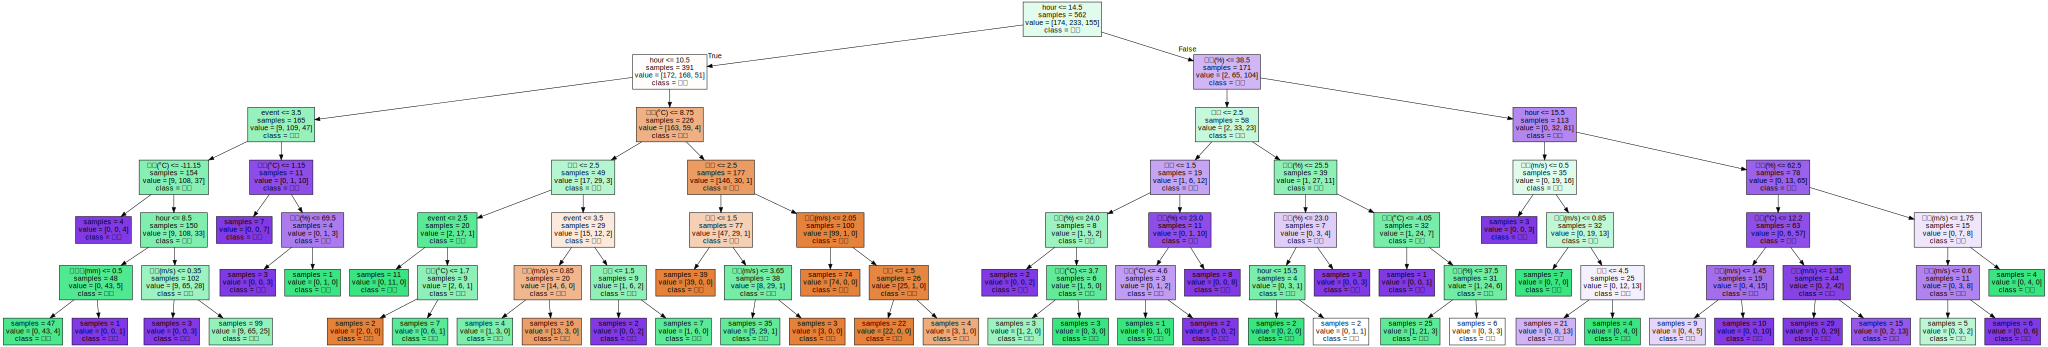

In [21]:
export_graphviz(estimator, out_file="dotfile/feat_dt_2nd.dot", class_names=['혼잡', '보통', '여유'], feature_names = X.columns, impurity = False, filled = True)
with open("dotfile/feat_dt_2nd.dot", encoding="UTF8") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

#### 각 특성들의 **중요도 수치** 확인
* 해당 모델의 중요도를 dataframe에 넣음

In [22]:
fe = estimator.feature_importances_  # 특성 중요도 수치
fe_im_df = pd.DataFrame(fe, index=X.columns)
fe_im_df

,0
계절,0.001638
event,0.048801
요일,0.189839
교시,0.010573
hour,0.481761
기온(°C),0.103720
풍속(m/s),0.081705
강수량(mm),0.006348
습도(%),0.075615


In [23]:
fe_im_df.info()

# 해당 열의 이름을 importance로 지정
fe_im_df.columns = ['importance']
fe_im_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 계절 to 습도(%)
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9 non-null      float64
dtypes: float64(1)
memory usage: 444.0+ bytes


,importance
계절,0.001638
event,0.048801


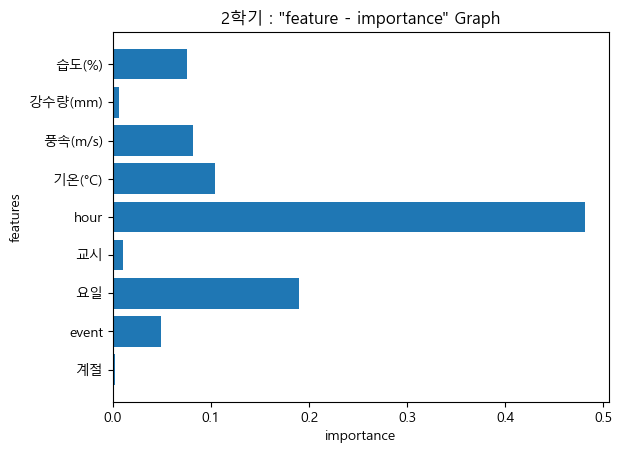

In [29]:
### 중요도를 시각화

fe_df = fe_im_df[fe_im_df['importance'] > 0]

### figure size
# plt.figure(figsize=(5, 8))

### bar plot : matplotlib.pyplot 모듈의 barh() 함수를 사용해서 수평 막대 그래프를 그림
plt.barh(fe_df.index.to_list(), fe_df['importance'])
plt.title('2학기 : "feature - importance" Graph')
plt.xlabel('importance')
plt.ylabel('features')

plt.rcParams['font.family'] = 'Malgun Gothic'     # 한국어 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False        # 마이너스 깨짐 방지

# 파일로 저장
plt.savefig('../visualization/png/feat_dt_2nd_feature_importance.png', dpi=300)

plt.show()

### 학습시킨 모델의 지표를 확인

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_target, pred)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(test_target, pred)
print("\nAccuracy: {:.2f}%".format(accuracy * 100))

Confusion Matrix:
[[52  5  2]
 [ 4 57 13]
 [ 0 25 30]]

Accuracy: 73.94%


In [26]:
# y로 나타난 혼잡도의 고유값이 몇 번 나타나는지 세기
value_counts = dt_data['혼잡도'].value_counts()
print(f"혼잡도 각 속성에 대한 행 개수:\n{value_counts}")

혼잡도 각 속성에 대한 행 개수:
혼잡도
보통    307
혼잡    233
여유    210
Name: count, dtype: int64


In [27]:
# Precision, Recall, F1 Score
precision = precision_score(test_target, pred, average='macro') 
recall = recall_score(test_target, pred, average='macro')
f1 = f1_score(test_target, pred, average='macro')
# average: 사용하여 여러 클래스에 대한 평균을 어떻게 취할지 정의
   # average='macro': 클래스 간 샘플 불균형이 있더라도 모든 클래스를 같은 가중치로 취급하지만,
   # 각 클래스를 동일하게 중요하게 여기기 때문에 macro로 선정


print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.75
Recall: 0.73
F1 Score: 0.74


### 학습시킨 모델 저장

In [28]:
# 모델 저장
with open('../run/model_load/feat_dt_2nd.pkl', 'wb') as file:
    pickle.dump(estimator, file)